In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time

In [4]:
df = pd.read_csv("TSLA.csv", parse_dates=["Date"])
df.set_index("Date", inplace=True)

In [5]:
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-09-30,48.796001,47.222000,48.599998,48.174000,29399000.0,48.174000
2019-10-01,49.189999,47.826000,48.299999,48.938000,30813000.0,48.938000
2019-10-02,48.930000,47.886002,48.658001,48.625999,28157000.0,48.625999
2019-10-03,46.896000,44.855999,46.372002,46.605999,75422500.0,46.605999
2019-10-04,46.956001,45.613998,46.321999,46.285999,39975000.0,46.285999
...,...,...,...,...,...,...
2022-04-05,1152.869995,1087.300049,1136.300049,1091.260010,26691700.0,1091.260010
2022-04-06,1079.000000,1027.699951,1073.469971,1045.760010,29782800.0,1045.760010
2022-04-07,1076.589966,1021.539978,1052.390015,1057.260010,26482400.0,1057.260010


In [6]:
df = df[["Close"]]

In [7]:
df.head()

,Close
Date,
2019-09-30,48.174000
2019-10-01,48.938000
2019-10-02,48.625999
2019-10-03,46.605999
2019-10-04,46.285999


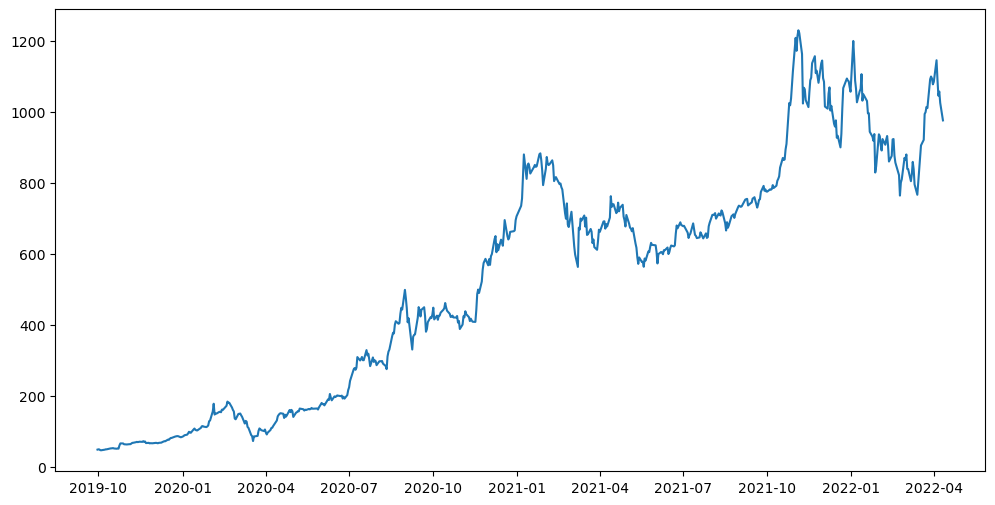

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'])

In [9]:
def df_to_windowed_df(df, first_date_str, last_date_str, n=3):
    """
    Turns a time series into a supervised learning windowed DataFrame.

    Parameters:
    - df: pd.DataFrame with a datetime index and a single column of values
    - first_date_str: start date as a string (e.g. '1986-03-18')
    - last_date_str: end date as a string (e.g. '2022-03-23')
    - n: number of lagged steps to include (e.g. 3)

    Returns:
    - pd.DataFrame with columns: Target Date, Target-n, ..., Target-1, Target
    """
    # Copy and filter based on date range
    df = df.copy()
    df = df.loc[first_date_str:last_date_str]

    windowed_data = []

    for i in range(n, len(df)):
        # Row: [Target Date, Target-n, ..., Target-1, Target]
        window = {
            "Target Date": df.index[i].strftime('%Y-%m-%d'),
        }
        for j in range(n, 0, -1):
            window[f"Target-{j}"] = df["Close"].iloc[i - j]
        window["Target"] = df["Close"].iloc[i]
        windowed_data.append(window)

    return pd.DataFrame(windowed_data)


In [10]:
windowed_df = df_to_windowed_df(df, "2019-09-30	", "2022-04-11", n=3)
print(windowed_df.head())


  Target Date   Target-3   Target-2   Target-1     Target
0  2019-10-03  48.174000  48.938000  48.625999  46.605999
1  2019-10-04  48.938000  48.625999  46.605999  46.285999
2  2019-10-07  48.625999  46.605999  46.285999  47.543999
3  2019-10-08  46.605999  46.285999  47.543999  48.009998
4  2019-10-09  46.285999  47.543999  48.009998  48.905998


In [11]:
def windowed_df_to_date_X_y(windowed_dataframe):
    df_as_np = windowed_dataframe.to_numpy()
    
    dates = df_as_np[:,0]
    
    middle_matrix = df_as_np[:,1:-1]
    X = middle_matrix.reshape((len(dates), middle_matrix.shape[1],1))
    
    Y = df_as_np[:,-1]
    
    return dates, X.astype(np.float32), Y.astype(np.float32)

In [12]:
dates, X, y = windowed_df_to_date_X_y(windowed_df)
dates.shape, X.shape, y.shape


((636,), (636, 3, 1), (636,))

([], [])

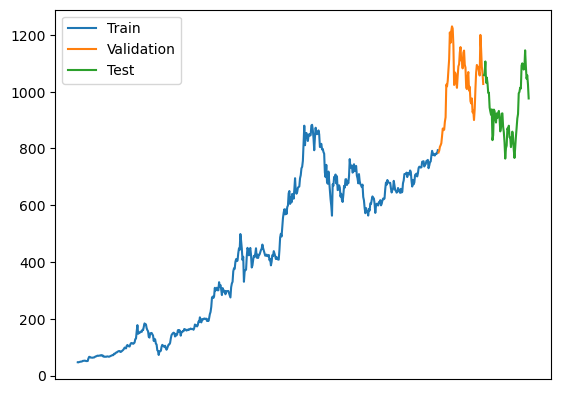

In [13]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train','Validation','Test'])

plt.xticks([]) #Too densely populated


In [14]:
!pip install tensorflow


from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, regularizers
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import RootMeanSquaredError

model = Sequential([
    layers.Input((3, 1)),

    layers.LSTM(
        64,
        kernel_regularizer=regularizers.l2(1e-4),
        recurrent_regularizer=regularizers.l2(1e-4),
        dropout=0.2,
        recurrent_dropout=0.2
    ),
    layers.BatchNormalization(),

    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.2),

    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.2),

    layers.Dense(1)
])

model.compile(
    loss='mse',
    optimizer=Adam(learning_rate=0.001),
    metrics=[
        RootMeanSquaredError(name='rmse'),
        'mean_absolute_error'
    ]
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=2
)


Epoch 1/100
16/16 - 5s - 318ms/step - loss: 247288.4062 - mean_absolute_error: 419.9178 - rmse: 497.2810 - val_loss: 1074906.1250 - val_mean_absolute_error: 1030.6718 - val_rmse: 1036.7769 - learning_rate: 0.0010
Epoch 2/100
16/16 - 0s - 12ms/step - loss: 245771.6562 - mean_absolute_error: 418.2891 - rmse: 495.7536 - val_loss: 1073043.7500 - val_mean_absolute_error: 1029.7687 - val_rmse: 1035.8783 - learning_rate: 0.0010
Epoch 3/100
16/16 - 0s - 11ms/step - loss: 243198.2344 - mean_absolute_error: 415.7165 - rmse: 493.1513 - val_loss: 1070115.3750 - val_mean_absolute_error: 1028.3479 - val_rmse: 1034.4639 - learning_rate: 0.0010
Epoch 4/100
16/16 - 0s - 10ms/step - loss: 238875.5625 - mean_absolute_error: 411.4395 - rmse: 488.7490 - val_loss: 1064940.2500 - val_mean_absolute_error: 1025.8450 - val_rmse: 1031.9595 - learning_rate: 0.0010
Epoch 5/100
16/16 - 0s - 11ms/step - loss: 231432.4844 - mean_absolute_error: 404.4563 - rmse: 481.0743 - val_loss: 1053357.6250 - val_mean_absolute_er

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
508
508


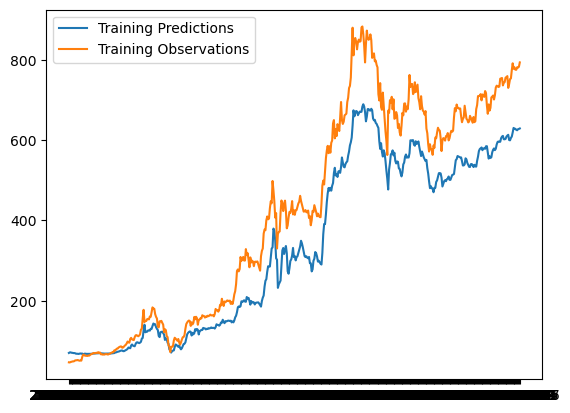

In [54]:
train_predictions = model.predict(X_train).flatten()

print(len(X_train))
print(len(train_predictions))

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

# On this first graphic
The orange line shows the actual stock price over our training period, and the blue line shows the model’s own forecasts during the same timeframe. Early on, when Tesla was trading in the $60 –$200 range, the blue line roughly follows. But as the price climbs above $ 400    and then surges toward $800–$900, the blue line starts to lag—consistently underestimating by several hundred dollars.

Takeaway: Even when “learning” from historical data, the model struggles to keep pace during big rallies. It tends to undershoot peaks.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


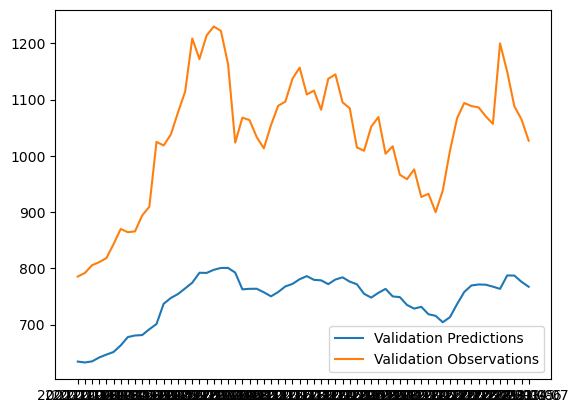

In [55]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

# 2. Validation Period – Chart 2
Next, we “park” the model and show it new data it has never seen before (the validation set). Here, the orange curve again is the real Tesla price—this time climbing from about $780 up to $1,200. Meanwhile, the blue forecasts stay flat in the $650–$800 range, barely moving.

Takeaway: On fresh data, the model effectively reverts to predicting a middle‐of‐the‐road price, completely missing large swings. In business terms, it’s as if our “crystal ball” just tells us today’s price will be close to a month‐long average—hardly useful when prices can jump or drop by hundreds of dollars in a week.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


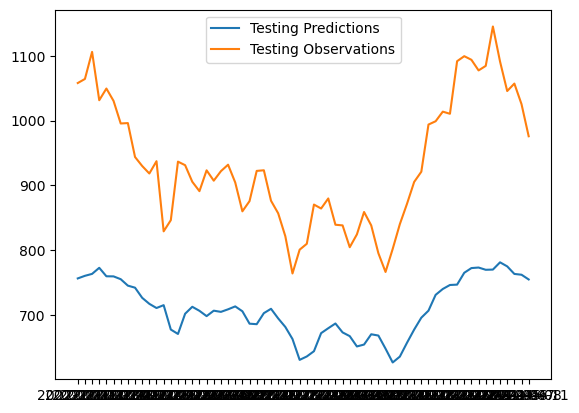

In [56]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

# 3. Testing Period – Chart 3
Finally, we test on a completely separate set of recent days. Again, real prices (orange) range between $760 and $1,150. The model’s predictions (blue) again sit in the $650–$780 band, failing to capture either the downturn or the mid‐cycle rally.

Takeaway: Out‐of‐sample performance remains poor. For a business needing actionable forecasts—say, to time purchases or hedges—it’s not reliable.

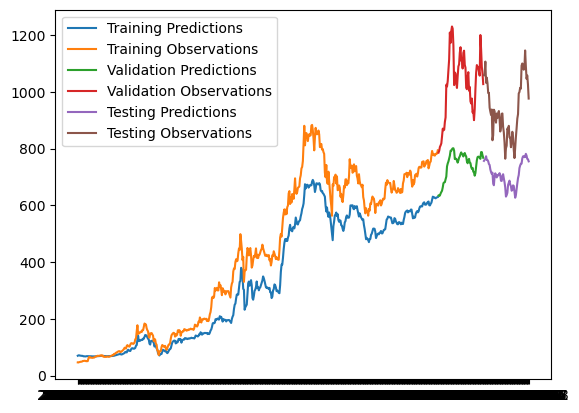

In [58]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])


# 4. Combined View – Chart 4
This last chart stitches together all three phases—training, validation, and testing—so you can see the consistent pattern. Blue forecasts trail orange actuals every time prices jump or drop sharply.

# Conclusion
At this stage, the LSTM underperforms our simpler ARIMA approach (which had an average error in the teens of dollars). With a validation RMSE of about $387, it’s not accurate enough for real‐world trading or risk management. To make a deep‐learning model more useful, we’d need more context—like adding trading volume or volatility signals—and a different setup. For now, if your priority is sharper profit forecasting or risk management, this LSTM isn’t ready for prime time.